In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mcmclib.metropolis import mala_adapt

import os
import json
import pandas as pd
from base_rl_mcmc.toolbox import flat
import bridgestan as bs
from posteriordb import PosteriorDatabase

import stan

import nest_asyncio
nest_asyncio.apply()

In [2]:
# Load DataBase Locally
pdb_path = os.path.join(os.getcwd(), "posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-checkerboard-test-checkerboard")
stan_file_path = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_file_path, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [3]:
alpha = 10 * [0.3]
epoch = 9 * [1_000] + [1_1000]
x, _, _, _, _, _ = mala_adapt(
    fp=log_p,
    fg=grad_log_p,
    x0=np.array([0., 0.]),
    h0=0.1,
    c0=np.eye(2),
    alpha=alpha,
    epoch=epoch,
    pb=True)

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


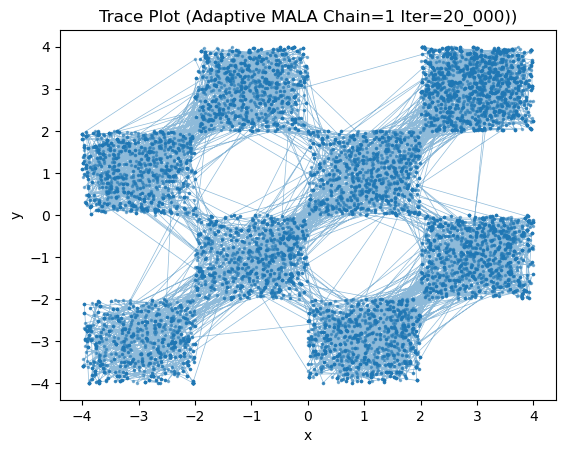

In [4]:
plt.plot(x[-1][:, 0], x[-1][:, 1], 'o-', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title("Trace Plot (Adaptive MALA Chain=1 Iter=20_000))")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

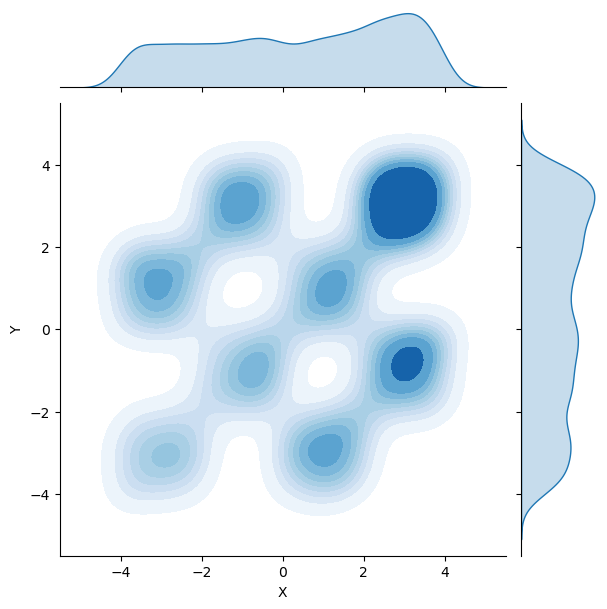

In [5]:
# Marginal Plot
sns.jointplot(x=x[-1][:, 0], y=x[-1][:, 1], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [6]:
num = 1000
x = np.linspace(-4, 4, num)
y = np.linspace(-4, 4, num)
X, Y = np.meshgrid(x, y)

Z = np.zeros((num, num))

In [7]:
for i in range(len(x)):
    for j in range(len(y)):
        Z[i, j] = np.exp(log_p(np.array([x[i], y[j]])))

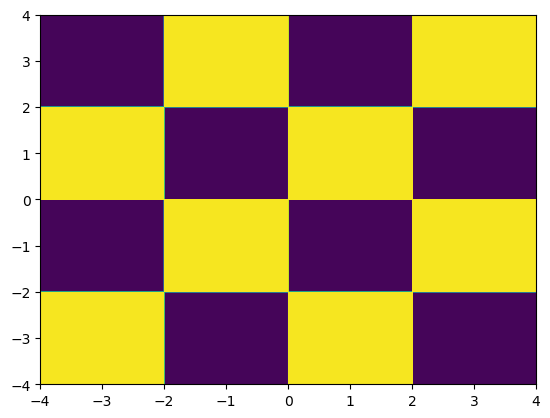

In [8]:
plt.contourf(X, Y, Z.T, 50, cmap='viridis')